### TFM - GANs

In [1]:
import numpy as np 
import pandas as pd 

import os
import matplotlib.pyplot as plt

from tqdm import tqdm, tqdm_notebook
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing import image
from tensorflow.keras import models, layers, optimizers, applications
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,Conv2D,MaxPooling2D,GlobalMaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Multiply, Dot, Concatenate, Input, UpSampling2D, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from sklearn.metrics import classification_report

from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split

from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot


In [2]:
def image_load(directory, filename,sizeh = 224,sizev = 224,grayscale = False):
    '''Join directory and filename, load image, reshape to sizeh,sizev and normalize'''
    filename=os.path.join(directory, filename)
    if grayscale == False:
        im=tf.keras.preprocessing.image.load_img(filename,target_size=(sizeh, sizev)) #Full name to avoid variable interference
        im=np.reshape(im,(sizeh,sizev,3))
    else:
        im=tf.keras.preprocessing.image.load_img(filename,target_size=(sizeh, sizev),color_mode = 'grayscale')
        im=np.reshape(im,(sizeh,sizev))
    im=im.astype('float32') / 255
    return im

In [5]:
df=pd.read_excel('imt_data.xlsx')
df.head()

,File_name,Label_file_name,ID,Side,Followup,Extension,IMT,Class,Exists?
0,050080144_LCCAg.png,_data_CCA2_050080144_LCCAg.png,50080,LCCAg,144,.png,0.617,0,True
1,050080144_RCCAg.png,_data_CCA2_050080144_RCCAg.png,50080,RCCAg,144,.png,0.947,0,True
2,050096156_LCCAg.png,_data_CCA2_050096156_LCCAg.png,50096,LCCAg,156,.png,0.770,0,True
3,050096156_RCCAg.png,_data_CCA2_050096156_RCCAg.png,50096,RCCAg,156,.png,0.715,0,True
4,050101156_LCCAg.png,_data_CCA2_050101156_LCCAg.png,50101,LCCAg,156,.png,0.851,0,True


In [6]:
kv_dict= dict(zip(df['File_name'].values,df['Class'].values))
dict(list(kv_dict.items())[:8])

{'050080144_LCCAg.png': 0,
 '050080144_RCCAg.png': 0,
 '050096156_LCCAg.png': 0,
 '050096156_RCCAg.png': 0,
 '050101156_LCCAg.png': 0,
 '050101156_RCCAg.png': 0,
 '050194156_LCCAg.png': 0,
 '050194156_RCCAg.png': 0}

In [7]:
#Create new images from images with plaque & modify the old ones to be smaller
Data = []
Label = []

directory_file = 'CCA2_png'

counter = 0
for filename in tqdm_notebook(os.listdir(directory_file)) :
    if filename.endswith(".png") or filename.endswith(".jpg"): 
        im_data = image_load(directory_file, filename, sizeh = 224, sizev = 224)
        #Apply transformation to orginal images
        Data.append(im_data.astype('float32'))
        Label.append(kv_dict.get(filename))

In [8]:
# (train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

train_images, train_labels = np.array(Data)[...,0],np.array(Label) #Take only 1 channel as we will use grayscale 

train_images = train_images.reshape(train_images.shape[0], 224, 224, 1).astype('float32')
# train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

train_images = (train_images * 2) -1 # Move normalized images from [0,1] to [-1, 1]

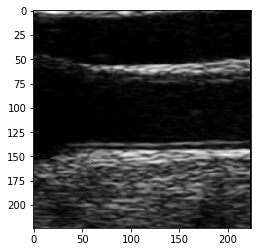

In [9]:
plt.imshow((train_images[0,...,0] + 1)/2,cmap = 'gray')

In [10]:
# BUFFER_SIZE = 60000
BUFFER_SIZE = 4751
BATCH_SIZE = 128
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


In [11]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*128, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 128)))
    assert model.output_shape == (None, 7, 7, 128) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(4, 4), padding='same', use_bias=False))
    assert model.output_shape == (None, 56, 56, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(4, 4), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 224, 224, 1)

    return model

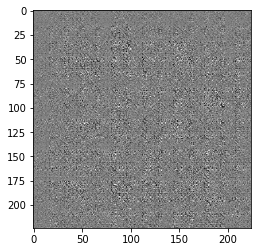

In [12]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [13]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same', input_shape=[224, 224, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [14]:
# Use the (as yet untrained) discriminator to classify the generated images as real or fake. 
# The model will be trained to output positive values for real images, and negative values for fake images.
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00049137]], shape=(1, 1), dtype=float32)


In [15]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [16]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [17]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


In [18]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [19]:
checkpoint_dir = './GAN_training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [21]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 4 #16 in the example

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [22]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [23]:
import time
from IPython import display

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed)

In [24]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(12,12))

    for i in range(predictions.shape[0]):
        plt.subplot(2, 2, i+1)
#         plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5,cmap = 'gray') #Pixels to 255
        plt.imshow((predictions[i, :, :, 0] + 1 )/ 2,cmap = 'gray') #Pixels to 255
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

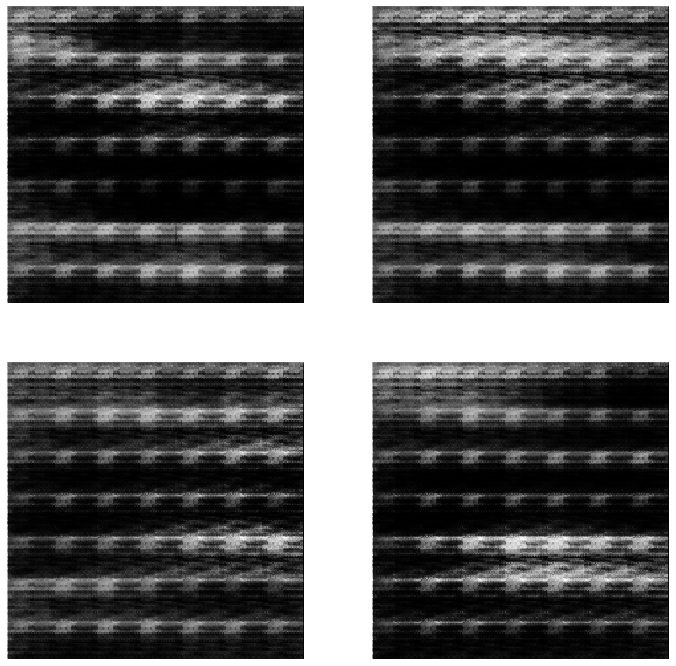

In [98]:
#Train the model
train(train_dataset, EPOCHS)

In [25]:
#restore checkpoint - useful to continue training
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

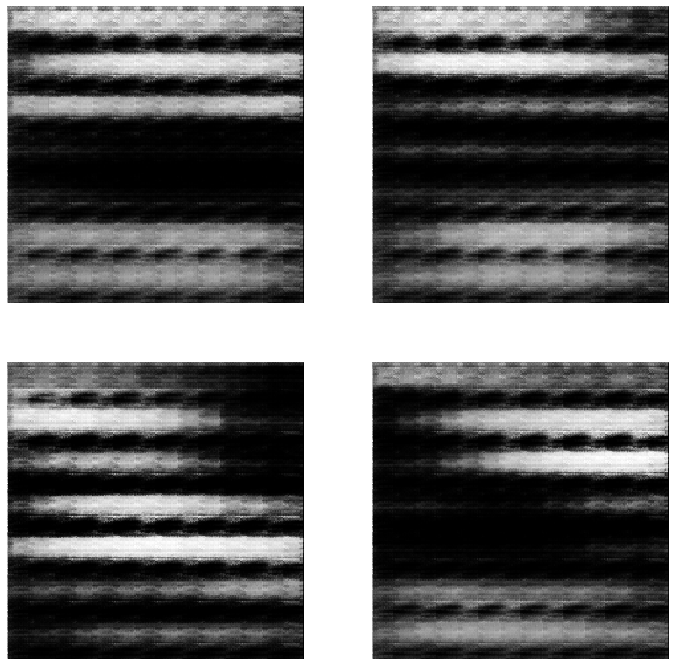

Time for epoch 19 is 331.3526349067688 sec


In [ ]:
#Train the model - using the previous checkpoint of 50
train(train_dataset, EPOCHS)